In [51]:
import pandas as pd
import pyreadstat as st
import pingouin as pg
import numpy as np

path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECMT04\problem_set_6\eurosec.dta"

df, meta = st.read_dta(path)
df.head()

,pais,s1,s2,s3,s4,s5,s6,s7,s8,s9
0,Belgica,3.300000,0.9,27.600000,0.9,8.2,19.100000,6.2,26.600000,7.2
1,Dinamarca,9.200000,0.1,21.799999,0.6,8.3,14.600000,6.5,32.200001,7.1
2,Francia,10.800000,0.8,27.500000,0.9,8.9,16.799999,6.0,22.600000,5.7
3,Alemania Este,6.700000,1.3,35.799999,0.9,7.3,14.400000,5.0,22.299999,6.1
4,Irlanda,23.200001,1.0,20.700001,1.3,7.5,16.799999,2.8,20.799999,6.1


In [52]:
ndf = df.iloc[:,1:]

In [68]:
import numpy as np
import pandas as pd
from sklearn.utils.extmath import randomized_svd
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

class FA():
    """
    Clase para análisis exploratorio de los Factores de una matriz de datos mediante método de Factores Principales.

    Esta clase:
        (1) Entrena un modelo de análisis factorial mediante el Método de Factores Principales ("Principal Factor Method"), según se define en Rencher (2002, chap. 13);
        (2) Devuelve: eigenvalues, eigenvectors, loading matrix, communalities, uniquenesses, correlation matrix;
        (3) Permite al generación de una rotación de las cargas ("orthogonal varimax rotation").

    Parámetros
    ----------
    X : np.ndarray
        Matriz de datos.
    n_factors : int, opcional
        Número de factores a extraer.
        Default es None.
    svd_method : {‘randomized’, 'np.svd'}
        Método para la realización de la descomposicón en valores singulares ("Singular Value Decomposition").
        Default es 'randomized', de librería scikit-learn. Para cualquier otra opción, SVD será realizada desde numpy.

    Atributos
    ---------
    get_eig: :obj:`numpy.ndarray`
        Matrices de autovalores y autovectores.
    get_loadings: :obj:`numpy.ndarray`
        Matriz de cargas.
    get_communalities_uniquenesses: :obj:`numpy.ndarray`
        Mtrices de comunalidades y unicidades.
    get_fa: :obj: personalizado
        Salida similiar a STATA.
    get_comparative_corr_matrix: :obj: personalizado
        Comparación para la matriz de correlaciones (estimada vs. original).
    get_rotated_loadings: :obj:`numpy.ndarray`
        Cargas rotadas. Permite ajuste Kaiser (None por Default).

    """
    def __init__(self, X: np.ndarray, n_factors: int=None, svd_method="randomized"):
        self.X = X
        self.n_factors = n_factors
        self.svd_method = svd_method

    def get_eig(self):
        """ 
        Regresa los autovalores y autovectores de la matriz de correlación corregida según Método de Factores Principales,
        de acuerdo al método de SVD seleccionado. 
        """ 

        self.X_corr = np.corrcoef(self.X, rowvar=False)
        self.X_corr_inv = np.linalg.inv(self.X_corr)
        self.X_corr_inv_diag = np.diag(self.X_corr_inv)
        self.R = 1 - (1 / self.X_corr_inv_diag)
        self.X_corr_o = self.X_corr.copy()
        np.fill_diagonal(self.X_corr, self.R)
        self.eigenvalues, _ = np.linalg.eig(self.X_corr) #Para conocer los autovalores negativos
        if self.svd_method == "randomized_svd":
            self.eigenvectors, self.eigenvalues_p, _ = randomized_svd(self.X_corr, n_components=self.X_corr.shape[1], random_state=1234567890)
        else:
            self.eigenvectors, self.eigenvalues_p, _ = np.linalg.svd(self.X_corr, full_matrices=False)

        return self.eigenvalues, self.eigenvectors

    def get_loadings(self):
        """ 
        Regresa las cargas de los Factores, conservando solo aquellas cargas cuyos autovalores sean positivos.
        """  

        self.get_eig()

        self.loadings = self.eigenvectors * np.sqrt(self.eigenvalues_p)
        positive_filter = np.array([i for i, value in enumerate(np.round(self.eigenvalues_p, decimals=10)) if value in np.round(self.eigenvalues, decimals=10)])
        self.positive_loadings = self.loadings[:, positive_filter]

        if self.n_factors == None:
            self.positive_loadings
        else:
            self.positive_loadings = self.positive_loadings[:, :self.n_factors]

        return self.positive_loadings
    
    def get_communalities_uniquenesses(self):
        """ 
        Regresa las comunalidades y unicidades de los Factores.
        """ 

        self.get_loadings()
        self.communalities, self.uniquenesses = np.sum((self.positive_loadings**2), axis=1), 1 - np.sum((self.positive_loadings**2), axis=1)

        return self.communalities, self.uniquenesses
        
    
    def get_fa(self):
        """
        Regresa un resumen detallado de análisis factorial, replicando salida de STATA.
        """      

        self.get_communalities_uniquenesses()                 
        loadings_matrix = pd.DataFrame(self.positive_loadings, columns=[f"Factor {i+1}" for i in range(self.positive_loadings.shape[1])], index=[f"x{i+1}" for i in range(self.positive_loadings.shape[0])]).reset_index(names='Variable')
        loadings_matrix = pd.concat([loadings_matrix, pd.DataFrame(self.uniquenesses, columns=['Uniqueness']), pd.DataFrame(self.communalities, columns=['Communality'])], axis=1)
        eigenv_matrix = pd.DataFrame(np.sort(self.eigenvalues)[::-1], columns=['Eigenvalue'], index=[f"Factor {i+1}" for i in range(self.eigenvalues.shape[0])]).reset_index(names='Factor')
        eigenv_proportion = [np.sort(self.eigenvalues)[::-1][i] / np.sum(np.sort(self.eigenvalues)[::-1]) for i in range(len(self.eigenvalues))]
        eigenv_proportion_cs = np.cumsum(eigenv_proportion)
        eigenv_matrix = pd.concat([eigenv_matrix, pd.DataFrame(eigenv_proportion, columns=['Proportion']), pd.DataFrame(eigenv_proportion_cs, columns=['Cumulative'])], axis=1)

        eigenv_table = tabulate(eigenv_matrix, headers='keys', tablefmt="fancy_grid", showindex=False, floatfmt=".4f")
        loadings_table = tabulate(loadings_matrix, headers='keys', tablefmt="fancy_grid", showindex=False, floatfmt=".4f")

        eigenv_lines = eigenv_table.splitlines()
        loadings_lines = loadings_table.splitlines()

        max_lines = max(len(eigenv_lines), len(loadings_lines))
        eigenv_lines += [''] * (max_lines - len(eigenv_lines))
        loadings_lines += [''] * (max_lines - len(loadings_lines))

        combined_output = "\n".join(f"{eigenv: <40}   {loading}" for eigenv, loading in zip(eigenv_lines, loadings_lines))
        
        print("Resultados de Factor Analysis")
        print(combined_output)
    
    def get_comparative_corr_matrix(self):
        """
        Regresa una comparación de la matriz de correlaciones (estimada por el modelo factorial vs. original).
        """
        self.get_communalities_uniquenesses()
        estimated_corr = self.positive_loadings @ self.positive_loadings.T + np.diag(self.uniquenesses)
        estimated_corr_matrix = pd.DataFrame(estimated_corr, columns=[f"x{i+1}" for i in range(estimated_corr.shape[1])], index=[f"x{i+1}" for i in range(estimated_corr.shape[0])]).reset_index(names='Variables')
        corr = self.X_corr_o
        corr_matrix = pd.DataFrame(corr, columns=[f"x{i+1}" for i in range(corr.shape[1])], index=[f"x{i+1}" for i in range(corr.shape[0])]).reset_index(names='Variables')

        est_corr_table = tabulate(estimated_corr_matrix, headers='keys', tablefmt="fancy_grid", showindex=False, floatfmt=".4f")
        corr_table = tabulate(corr_matrix, headers='keys', tablefmt="fancy_grid", showindex=False, floatfmt=".4f")

        est_corr_lines = est_corr_table.splitlines()
        corr_lines = corr_table.splitlines()

        max_lines = max(len(est_corr_lines), len(corr_lines))
        est_corr_lines += [''] * (max_lines - len(est_corr_lines))
        corr_lines += [''] * (max_lines - len(corr_lines))

        combined_output = "\n".join(f"{eigenv: <40}   {loading}" for eigenv, loading in zip(est_corr_lines, corr_lines))
     

        print("Matriz de correlación estimada (izquierda) vs. Matriz de correlación (derecha)")
        print(combined_output)
        

    def get_rotated_loadings(self, kaiser=False):
        """
        Regresa la cargas rotadas del modelo factorial (orthogonal varimax rotation").
        Permite aplicar adecuación Kaiser.
        """
        self.get_communalities_uniquenesses()
        X = self.positive_loadings.copy()
        n_rows, n_cols = X.shape
        if n_cols < 2:
            return X

        # normalize the loadings matrix
        # using sqrt of the sum of squares (Kaiser)
        if kaiser:
            normalized_mtx = np.apply_along_axis(
                lambda x: np.sqrt(np.sum(x**2)), 1, X.copy()
            )
            X = (X.T / normalized_mtx).T

        # initialize the rotation matrix
        # to N x N identity matrix
        rotation_mtx = np.eye(n_cols)

        d = 0
        for _ in range(5000):
            old_d = d

            # take inner product of loading matrix
            # and rotation matrix
            basis = np.dot(X, rotation_mtx)

            # transform data for singular value decomposition using updated formula :
            # B <- t(x) %*% (z^3 - z %*% diag(drop(rep(1, p) %*% z^2))/p)
            diagonal = np.diag(np.squeeze(np.repeat(1, n_rows).dot(basis**2)))
            transformed = X.T.dot(basis**3 - basis.dot(diagonal) / n_rows)

            # perform SVD on
            # the transformed matrix
            U, S, V = np.linalg.svd(transformed)

            # take inner product of U and V, and sum of S
            rotation_mtx = np.dot(U, V)
            d = np.sum(S)

            # check convergence
            if d < old_d * (1 + 1e-5):
                break

        # take inner product of loading matrix
        # and rotation matrix
        X = np.dot(X, rotation_mtx)

        # de-normalize the data
        if kaiser:
            X = X.T * normalized_mtx
        else:
            X = X.T

        # convert loadings matrix to data frame
        rotated_loadings = X.T.copy()
        return rotated_loadings, rotation_mtx

In [5]:
from sklearn.decomposition import PCA
"""
Análisis de Componentes Principales - Matriz de Correlaciones
"""

ndf_media = ndf.mean()
ndf_de = ndf.std()
ndf_scaled = ((ndf - ndf_media) / ndf_de)

pca_cor = PCA()
componentes_cor = pca_cor.fit_transform(ndf_scaled)

varianza_cor = pca_cor.explained_variance_
std_componentes_cor = np.sqrt(pca_cor.explained_variance_) #Ver si eliminamos
varianza_explicada_cor = pca_cor.explained_variance_ratio_
varianza_explicada_acum_cor = np.cumsum(pca_cor.explained_variance_ratio_)
coeficientes_cor =  pca_cor.components_.T

#Generamos una tabla resumen
data_var_cor = {
    'Varianza (eigenvalues)': varianza_cor,
    'Desviación Estándar': std_componentes_cor,
    'Varianza Explicada': varianza_explicada_cor,
    'Varianza Explicada Acumulada': varianza_explicada_acum_cor
}

variablespca_cor = pd.DataFrame(data_var_cor, index=[f'Componente {i+1}' for i in range(len(varianza_cor))]).reset_index()
variablespca_cor

,index,Varianza (eigenvalues),Desviación Estándar,Varianza Explicada,Varianza Explicada Acumulada
0,Componente 1,6.317995,2.513562,0.574363,0.574363
1,Componente 2,1.683479,1.297490,0.153044,0.727407
2,Componente 3,1.164594,1.079163,0.105872,0.833279
3,Componente 4,0.711894,0.843738,0.064718,0.897997
4,Componente 5,0.335730,0.579422,0.030521,0.928517
5,Componente 6,0.246859,0.496849,0.022442,0.950959
6,Componente 7,0.178187,0.422122,0.016199,0.967158
7,Componente 8,0.141080,0.375606,0.012825,0.979984
8,Componente 9,0.125522,0.354291,0.011411,0.991395
9,Componente 10,0.060439,0.245844,0.005494,0.996889


In [6]:
coeficientespca_cor = pd.DataFrame(coeficientes_cor, columns=[f'Coeficiente (eigenvector) {i+1}' for i in range(coeficientes_cor.shape[1])], index=ndf.columns).reset_index()
coeficientespca_cor

,index,Coeficiente (eigenvector) 1,Coeficiente (eigenvector) 2,Coeficiente (eigenvector) 3,Coeficiente (eigenvector) 4,Coeficiente (eigenvector) 5,Coeficiente (eigenvector) 6,Coeficiente (eigenvector) 7,Coeficiente (eigenvector) 8,Coeficiente (eigenvector) 9,Coeficiente (eigenvector) 10,Coeficiente (eigenvector) 11
0,alybnh,0.207319,0.614599,0.107366,-0.097404,0.029139,-0.407543,0.246931,-0.148236,0.258871,0.129334,-0.473963
1,vestcal,0.244064,0.518492,-0.213953,-0.322483,-0.007669,-0.104561,-0.367050,-0.038077,-0.190699,-0.158901,0.559504
2,vivagelo,0.331483,-0.315462,-0.200766,0.014243,0.005283,-0.141543,-0.115422,-0.174513,0.770826,-0.261700,0.153602
3,mobymant,0.338676,-0.003750,0.061277,-0.292521,0.594885,0.565745,0.107695,-0.222869,-0.072436,-0.144729,-0.185857
4,salud,0.263526,0.331130,0.016627,0.608008,-0.339168,0.505243,-0.237383,-0.022137,0.075358,-0.055675,-0.122606
5,transp,0.162798,-0.125785,0.792448,0.138145,0.174569,-0.241629,-0.418826,-0.169085,-0.060780,0.067353,0.097584
6,comu,0.354926,-0.006054,0.204453,0.269472,-0.028800,-0.112608,0.690522,0.120830,-0.167228,-0.274256,0.389183
7,ocio,0.371612,-0.152903,-0.171382,0.017807,-0.056500,0.039483,0.099093,-0.207343,-0.047080,0.840948,0.204607
8,educ,0.328471,-0.292116,-0.248162,0.005633,-0.263862,-0.269347,-0.112722,-0.373528,-0.494608,-0.272123,-0.363415
9,esparc,0.350737,-0.073468,-0.207960,0.184049,0.361925,-0.205550,-0.219447,0.722784,-0.086062,0.066527,-0.197024


In [7]:
componentespca_cor = pd.DataFrame(componentes_cor, columns=[f'Componente {i+1} ' for i in range(componentes_cor.shape[1])], index=df.iloc[:,0]).reset_index()
componentespca_cor

,comunidad,Componente 1,Componente 2,Componente 3,Componente 4,Componente 5,Componente 6,Componente 7,Componente 8,Componente 9,Componente 10,Componente 11
0,Andalucía,-0.716259,0.025964,0.890907,0.594364,1.026202,0.051896,-0.313316,-0.119395,-0.142279,-0.216319,-0.031594
1,Aragón,0.170174,-0.300699,-0.684371,-0.198902,0.840605,0.115368,0.075018,-0.056482,0.141014,0.448895,0.050979
2,Asturias(Principado de),-0.503798,-0.403005,-0.045472,-0.274717,-0.607566,0.207044,0.440469,0.461272,-0.826246,-0.059336,0.351432
3,Balears (Illes),1.034238,-2.159153,1.030480,-0.970877,0.189214,0.944993,0.598493,0.137504,0.346308,-0.309716,0.008712
4,Canarias,-0.958532,-0.389314,0.913513,2.091652,-0.247227,0.186827,0.069889,-0.499243,-0.075582,0.011129,0.110252
5,Cantabria,-0.009262,1.098188,1.589464,-0.667732,-0.447328,-0.154428,-0.339692,0.042900,0.581731,0.064300,0.025296
6,Castilla y León,-2.149193,-0.109387,0.084514,0.037841,0.732378,-0.074073,0.311562,-0.123327,-0.043320,0.241412,-0.166345
7,Castilla-La mancha,-3.145387,0.240027,0.633599,-0.293641,0.240426,-0.403968,-0.460030,-0.166204,0.184992,-0.003359,0.469226
8,Cataluña,0.321922,-0.820155,0.197178,-0.127577,-1.169049,-0.230321,0.527131,-0.792709,0.120754,0.224454,-0.123633
9,Comunitat Valenciana,1.400881,-0.875885,1.281807,0.127830,0.161654,0.397186,-0.420111,0.472611,-0.327590,0.421126,-0.210190


In [69]:
fa = FA(ndf)
faa = fa.get_fa()
faa

Resultados de Factor Analysis
╒══════════╤══════════════╤══════════════╤══════════════╕   ╒════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤══════════════╤═══════════════╕
│ Factor   │   Eigenvalue │   Proportion │   Cumulative │   │ Variable   │   Factor 1 │   Factor 2 │   Factor 3 │   Factor 4 │   Factor 5 │   Factor 6 │   Factor 7 │   Factor 8 │   Uniqueness │   Communality │
╞══════════╪══════════════╪══════════════╪══════════════╡   ╞════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪══════════════╪═══════════════╡
│ Factor 1 │       3.4790 │       0.3924 │       0.3924 │   │ x1         │    -0.9797 │    -0.0722 │     0.0656 │    -0.0054 │     0.1447 │     0.0978 │     0.0166 │     0.0015 │      -0.0002 │        1.0002 │
├──────────┼──────────────┼──────────────┼──────────────┤   ├────────────┼────────────┼────────────┼────────────┼────────────┼────

In [81]:
L = fa.get_loadings()
sigma = ndf.corr()
sigma_inv = np.linalg.inv(sigma)
psi = np.diag(fa.get_communalities_uniquenesses()[1])
psi_inv = np.linalg.inv(psi)
s_ndf = (ndf - ndf.mean()) / ndf.std()
I = np.eye(5)

pd.options.display.float_format = '{:.7f}'.format
factors = (L.T@sigma_inv)@s_ndf.T
factors.T

,0,1,2,3,4,5,6,7
0,0.9325552,0.7894850,-0.1276111,-0.4430277,-0.3110405,0.0863465,-0.5383126,-1.0240350
1,0.3328615,1.6405754,1.2843598,-0.1381485,-0.2305520,-1.6253074,-0.5802067,0.3846887
2,0.4026058,0.7533618,-0.5391638,0.3901354,-0.4059464,0.1386793,-0.4718313,0.6361720
3,0.5400409,-0.1106135,-0.7581778,-0.2078419,-1.2790996,-0.9227974,0.7994644,-0.2902554
4,-0.2177193,0.4890645,0.1864849,-0.6302925,-0.4689404,1.9277845,0.0433581,0.6284136
5,0.1451640,0.5714499,0.7969803,1.7364889,-1.1637077,1.3542369,-0.2178996,0.1851598
6,0.5584478,-0.4714831,-0.8659660,0.5322048,-1.0589090,0.6337849,-3.0899696,-1.7102955
7,1.0014614,1.2111884,-0.0506237,-0.0570494,1.0785050,0.4982814,-0.9342362,1.6851910
8,0.9022378,0.2080310,-0.8502508,-1.5098251,-0.9093609,-0.0553133,-0.1289910,0.9954458
9,0.6258888,-0.1134437,-0.9759921,-0.0102890,0.6705118,1.3226159,0.9312892,-0.3325703


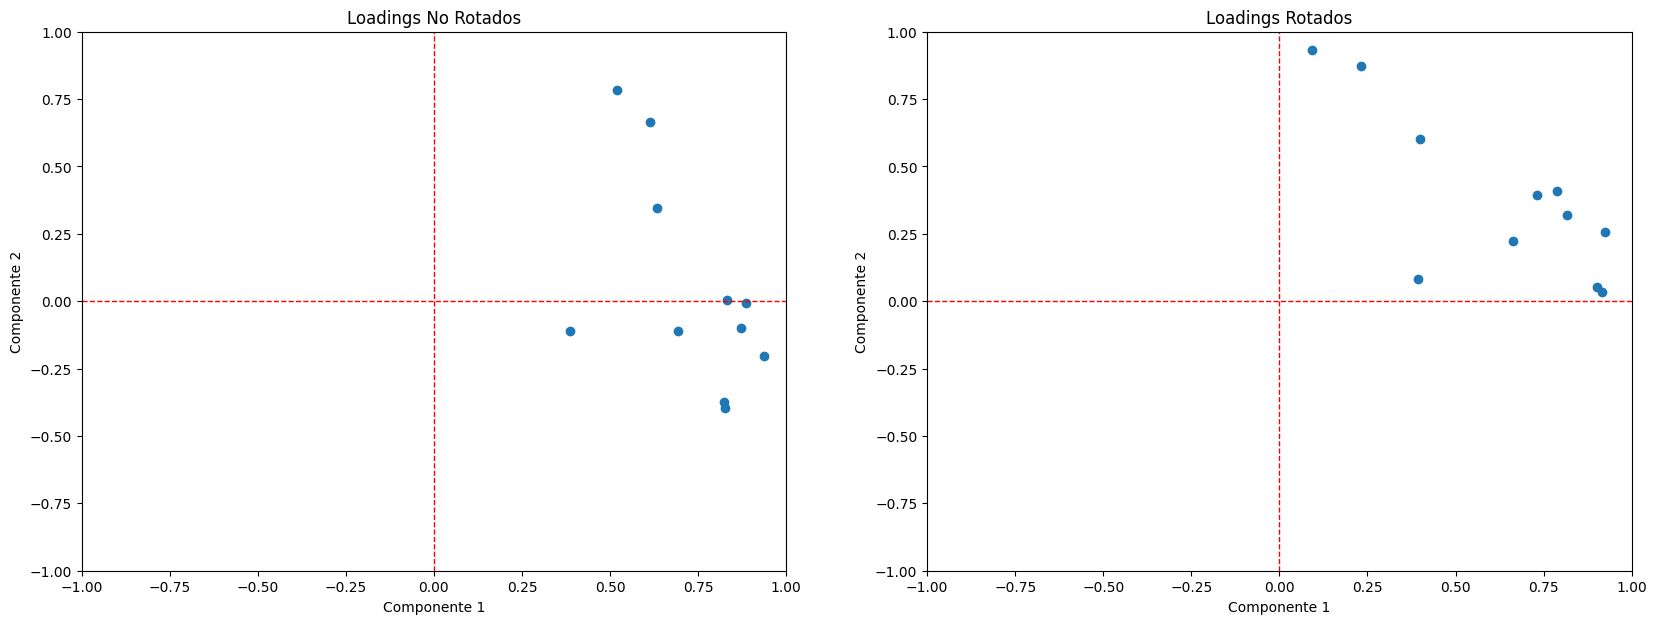

In [41]:
no_rotado = fa.get_loadings()*-1
rotado = fa.get_rotated_loadings()[0]*-1

import matplotlib.pyplot as plt

# Crear las figuras para los dos gráficos
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Scatter plot para los loadings no rotados
ax[0].scatter(no_rotado[:, 0], no_rotado[:, 1])
ax[0].set_title('Loadings No Rotados')
ax[0].set_xlabel('Componente 1')
ax[0].set_ylabel('Componente 2')

# Establecer los límites de los ejes x e y de -1 a 1
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)

# Agregar líneas verticales y horizontales en x=0 e y=0
ax[0].axhline(0, color='red', linestyle='--', linewidth=1)
ax[0].axvline(0, color='red', linestyle='--', linewidth=1)

# Scatter plot para los loadings rotados
ax[1].scatter(rotado[:, 0], rotado[:, 1])
ax[1].set_title('Loadings Rotados')
ax[1].set_xlabel('Componente 1')
ax[1].set_ylabel('Componente 2')

# Establecer los límites de los ejes x e y de -1 a 1
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)

# Agregar líneas verticales y horizontales en x=0 e y=0
ax[1].axhline(0, color='red', linestyle='--', linewidth=1)
ax[1].axvline(0, color='red', linestyle='--', linewidth=1)

# Mostrar los gráficos
plt.show()

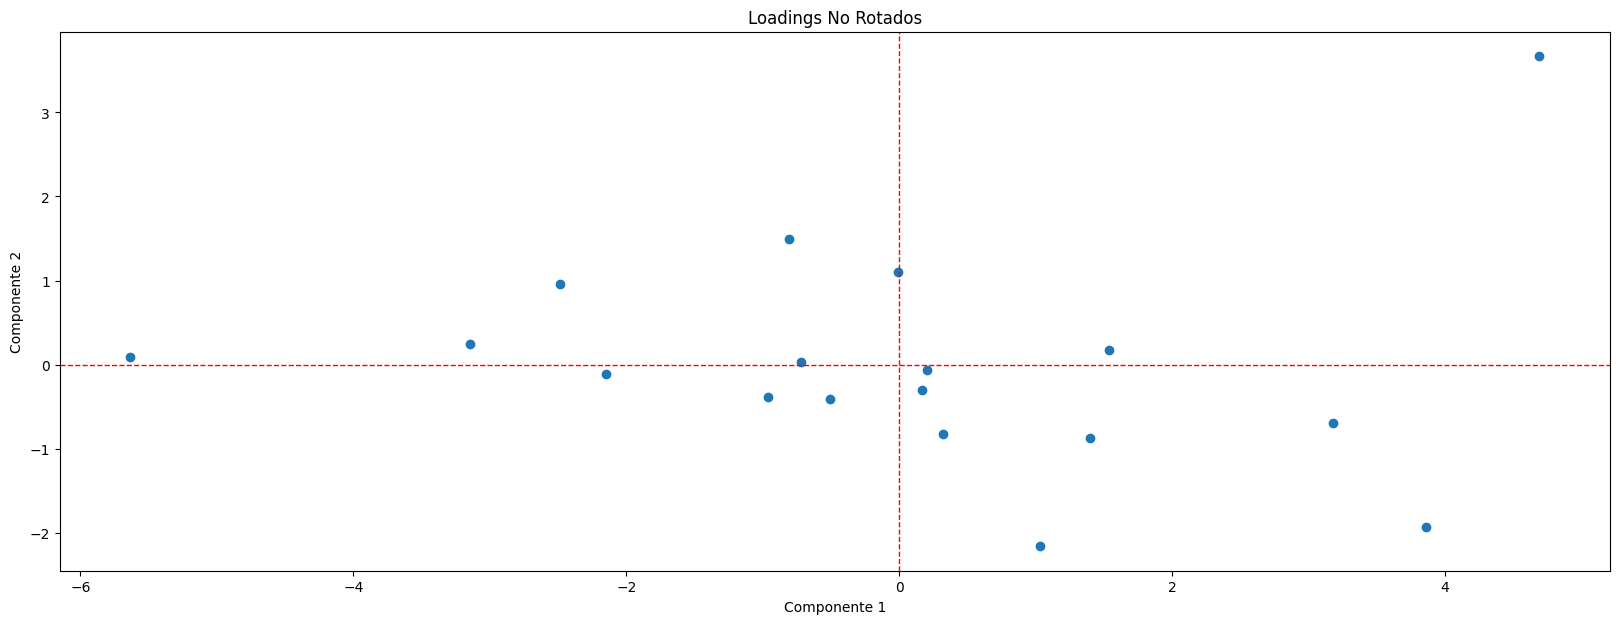

In [45]:
fig, ax = plt.subplots(figsize=(20, 7))

# Scatter plot para los loadings no rotados
ax.scatter(componentes_cor[:, 0], componentes_cor[:, 1])
ax.set_title('Loadings No Rotados')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')

ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.axvline(0, color='red', linestyle='--', linewidth=1)

plt.show()

In [49]:
ndf_mean = np.diag(ndf.mean().values)
er = digfa.get_communalities_uniquenesses()[1]
er

array([0.11941554, 0.18247986, 0.15996096, 0.30931803, 0.47792969,
       0.83894028, 0.21267618, 0.08178874, 0.18194778, 0.23222266,
       0.50941393])

In [10]:
from statsmodels.multivariate.factor import Factor


# Crear el modelo de Factor Analysis
factor_model = Factor(ndf.values, n_factor=2)

# Ajustar el modelo
factor_result = factor_model.fit()

# Imprimir el resumen del análisis de factores
print(factor_result.summary())

                             Factor analysis results
                         Eigenvalues                                              
----------------------------------------------------------------------------------
   y1     y2     y3     y4     y5     y6      y7      y8      y9     y10     y11  
----------------------------------------------------------------------------------
 6.0627 1.5460 0.5667 0.2734 0.0548 0.0127 -0.0368 -0.0884 -0.1638 -0.2095 -0.4091
----------------------------------------------------------------------------------
                                                                                  
----------------------------------------------------------------------------------
                         Communality                                              
----------------------------------------------------------------------------------
        y1     y2     y3     y4     y5     y6     y7     y8     y9    y10    y11  
----------------------------------

In [13]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=2, method='principal', rotation=None, bounds=None)  # Sin rotación

# Ajustar el análisis factorial a los datos
fa.fit(ndf)

# Obtener las cargas factoriales sin rotación
factor_loadings = fa.loadings_
pd.DataFrame(factor_loadings)

,0,1
0,0.521110,0.797436
1,0.613471,0.672738
2,0.833203,-0.409309
3,0.851284,-0.004865
4,0.662390,0.429637
5,0.409202,-0.163205
6,0.892128,-0.007855
7,0.934069,-0.198391
8,0.825632,-0.379018
9,0.881599,-0.095323


In [14]:
eigenvalues, _ = fa.get_eigenvalues()
pd.DataFrame(eigenvalues)

,0
0,6.317995
1,1.683479
2,1.164594
3,0.711894
4,0.335730
5,0.246859
6,0.178187
7,0.141080
8,0.125522
9,0.060439


In [15]:
fa.get_factor_variance()

(array([6.3179948 , 1.68347941]),
 array([0.57436316, 0.15304358]),
 array([0.57436316, 0.72740675]))

In [16]:
fa.transform(ndf)

array([[-0.29321894,  0.02059123],
       [ 0.06966509, -0.23847343],
       [-0.20624288, -0.31960827],
       [ 0.42339198, -1.71234539],
       [-0.39239982, -0.30875069],
       [-0.00379154,  0.87093245],
       [-0.87982744, -0.08675046],
       [-1.2876451 ,  0.19035681],
       [ 0.1317872 , -0.65043477],
       [ 0.57348669, -0.69463222],
       [-2.30695234,  0.07109428],
       [-0.32954961,  1.18187668],
       [ 1.58043394, -1.53098842],
       [-1.01727712,  0.75752754],
       [ 0.6311192 ,  0.142225  ],
       [ 1.30241386, -0.54745012],
       [ 0.08362892, -0.05424343],
       [ 1.92097791,  2.90907321]])

In [17]:
from factor_analyzer import FactorAnalyzer
fa_2 = FactorAnalyzer(n_factors=2, method='principal', rotation='varimax', bounds=None)  # Sin rotación

# Ajustar el análisis factorial a los datos
fa_2.fit(ndf)

# Obtener las cargas factoriales sin rotación
factor_loadings_2 = fa_2.loadings_
pd.DataFrame(factor_loadings)

,0,1
0,0.521110,0.797436
1,0.613471,0.672738
2,0.833203,-0.409309
3,0.851284,-0.004865
4,0.662390,0.429637
5,0.409202,-0.163205
6,0.892128,-0.007855
7,0.934069,-0.198391
8,0.825632,-0.379018
9,0.881599,-0.095323


In [18]:
eigenvalues_2, _ = fa_2.get_eigenvalues()
pd.DataFrame(eigenvalues_2)

,0
0,6.317995
1,1.683479
2,1.164594
3,0.711894
4,0.335730
5,0.246859
6,0.178187
7,0.141080
8,0.125522
9,0.060439


In [19]:
fa_2.transform(ndf)

array([[-0.26499301, -0.12720083],
       [ 0.17854263, -0.17275801],
       [-0.02106995, -0.37979156],
       [ 1.2152474 , -1.27849961],
       [-0.18821081, -0.46247303],
       [-0.4342608 ,  0.75495381],
       [-0.72163266, -0.51075265],
       [-1.21314317, -0.47175129],
       [ 0.43637801, -0.50000748],
       [ 0.84208   , -0.31984712],
       [-2.03989407, -1.07977574],
       [-0.87120613,  0.86396488],
       [ 2.13096178, -0.54836017],
       [-1.2588513 ,  0.15490032],
       [ 0.47805752,  0.43589036],
       [ 1.40267854,  0.1687495 ],
       [ 0.09951397, -0.00575456],
       [ 0.22980205,  3.4785132 ]])

In [22]:
pd.concat([pd.DataFrame(factor_loadings), pd.DataFrame(factor_loadings_2)], axis=1)

,0,1,0,1
0,0.521110,0.797436,0.058241,0.950825
1,0.613471,0.672738,0.200206,0.888167
2,0.833203,-0.409309,0.926583,0.056612
3,0.851284,-0.004865,0.742163,0.417016
4,0.662390,0.429637,0.363010,0.701122
5,0.409202,-0.163205,0.436351,0.060663
6,0.892128,-0.007855,0.779135,0.434628
7,0.934069,-0.198391,0.909865,0.289809
8,0.825632,-0.379018,0.905015,0.079188
9,0.881599,-0.095323,0.813268,0.353409


In [23]:
import pandas as pd
import pyreadstat as st
import pingouin as pg
import numpy as np

path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECMT04\problem_set_6\eurosec.dta"

df, meta = st.read_dta(path)
df.head()

,pais,s1,s2,s3,s4,s5,s6,s7,s8,s9
0,Belgica,3.300000,0.9,27.600000,0.9,8.2,19.100000,6.2,26.600000,7.2
1,Dinamarca,9.200000,0.1,21.799999,0.6,8.3,14.600000,6.5,32.200001,7.1
2,Francia,10.800000,0.8,27.500000,0.9,8.9,16.799999,6.0,22.600000,5.7
3,Alemania Este,6.700000,1.3,35.799999,0.9,7.3,14.400000,5.0,22.299999,6.1
4,Irlanda,23.200001,1.0,20.700001,1.3,7.5,16.799999,2.8,20.799999,6.1


In [24]:
df.describe()

,s1,s2,s3,s4,s5,s6,s7,s8,s9
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,19.130769,1.253846,27.007692,0.907692,8.165385,12.957692,4.000000,20.023077,6.546154
std,15.546570,0.970044,7.007763,0.376216,1.645586,4.575253,2.806564,6.829542,1.391468
min,2.700000,0.100000,7.900000,0.100000,2.800000,5.200000,0.500000,5.300000,3.200000
25%,7.700000,0.525000,23.000000,0.600000,7.525000,9.250000,1.225000,16.250000,5.700000
50%,14.450000,0.950000,27.550000,0.850000,8.350000,14.400000,4.650000,19.650001,6.700000
75%,23.675001,1.800000,30.200001,1.175000,8.975000,16.875000,5.925000,24.125000,7.075000
max,66.800003,3.100000,41.200001,1.900000,11.500000,19.100000,11.300000,32.400002,9.400000


In [26]:
ndf = df.iloc[:,1:]

In [43]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=5, method='principal', rotation=None)  # Sin rotación

# Ajustar el análisis factorial a los datos
fa.fit(ndf)

# Obtener las cargas factoriales sin rotación
factor_loadings = fa.loadings_
pd.DataFrame(factor_loadings)

,0,1,2,3,4
0,-0.978123,0.078221,-0.051026,0.028713,0.156769
1,-0.002471,0.901696,0.210816,0.063908,-0.120684
2,0.648909,0.518205,0.157732,-0.345132,-0.283726
3,0.477522,0.381073,0.588190,0.392223,0.217551
4,0.607237,0.074856,-0.160728,-0.666478,0.347580
5,0.707591,-0.511080,0.120656,-0.050018,-0.208999
6,0.138885,-0.662177,0.615738,-0.051424,0.206051
7,0.723444,-0.323313,-0.326972,0.411091,-0.162406
8,0.685002,0.295685,-0.393228,0.313503,0.378051


In [39]:
eigenvalues_3, _ = fa.get_eigenvalues()
eigenvalues_3

array([3.48715124e+00, 2.13017319e+00, 1.09895763e+00, 9.94482974e-01,
       5.43217767e-01, 3.83427644e-01, 2.25754046e-01, 1.36789882e-01,
       4.56251076e-05])

In [40]:
fa.transform(ndf)

array([[ 0.72045849, -0.87562986,  0.93292582,  0.0311938 , -0.28749589],
       [ 0.53917889, -1.75338782, -0.68343523, -0.96768963, -0.48717721],
       [ 0.47501449, -0.14309091,  0.59212826, -0.39778984, -0.48313581],
       [ 0.6572684 , -0.08654085,  0.22626469,  1.74356836, -1.03116511],
       [-0.46388651, -0.64762176,  0.72687195, -0.44550363,  0.83879744],
       [ 0.43874569,  0.51832554, -0.02357688, -1.08930166, -1.19260565],
       [ 0.62296547,  0.50065379,  1.15444367, -0.03495672, -0.12876898],
       [ 0.78604769, -0.87601276,  0.36050335, -1.77422472,  0.22232112],
       [ 0.69100187, -1.27164692,  0.58501396,  1.19198596,  0.28712387],
       [ 0.33877578,  0.71477112,  1.3125017 ,  0.01922312,  0.69056983],
       [ 0.1564758 , -0.84726725,  0.46244199,  0.29900658,  0.63333441],
       [-1.377586  ,  0.62003345,  0.3542607 , -1.19894755,  0.18433577],
       [ 0.45109012, -1.13476398,  0.28744169, -0.97324393,  0.52451497],
       [-0.43372938,  0.36748723, -0.1